## Outreach message prediction
ML implementation series for product managers, post 8

### DISCLAIMER: It is greatly beneficial if you know Python and ML basics before hand. If not, I would highly urge you to learn. This should be non-negotiable. This would form the basement for future posts in this series and your career as PM working with ML teams.

### The Problem

After Post 7's campaign response modeling success, our marketing team had a new challenge:

"We know WHO to target, but we're still sending generic messages. Can we personalize the message content itself to increase engagement?"

The team was manually creating 3-4 message variants per campaign, but with 50,000+ customers across diverse segments, one-size-fits-all messaging was leaving money on the table.

*The Challenge:*

Historical support tickets and campaign feedback contain rich text data showing customer preferences

Some customers respond to urgency ("24-hour flash sale!"), others to value ("Save 30%"), and others to exclusivity ("VIP early access")

Manual message creation doesn't scale

Need to predict which message tone/style will resonate with each customer



### The ML Solution: Neural Network Text Classification

*Why Neural Networks + NLP?*

Text data requires understanding semantic meaning, not just keywords

Neural networks can learn complex patterns in language

Can classify message preferences based on historical engagement

Scales to thousands of customers instantly

Approach:

Extract historical campaign messages and customer responses

Label messages by tone/style (Urgency, Value, Exclusivity, Informational)

Use customer features + past message engagement to train a neural network

Predict optimal message type for each customer

Auto-generate personalized campaign messages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load datasets
customers_df = pd.read_csv('cdp_customers.csv')
campaigns_df = pd.read_csv('cdp_campaign_responses.csv')
customer_features_df = pd.read_csv('cdp_customer_features.csv')
support_df = pd.read_csv('cdp_support_tickets.csv')

print("Data loaded successfully!")
print(f"Customers: {len(customers_df)}")
print(f"Campaign Responses: {len(campaigns_df)}")
print(f"Customer Features: {len(customer_features_df)}")


Data loaded successfully!
Customers: 5000
Campaign Responses: 5849
Customer Features: 5000


In [17]:
# Map message types to campaigns
message_type_mapping = {
    'Spring Sale 2024': 'Value',
    'Black Friday 2024': 'Urgency',
    'New Year Promotion 2025': 'Value',
    'Summer Collection Launch': 'Informational',
    'Customer Appreciation Week': 'Exclusivity',
    'Flash Sale Weekend': 'Urgency',
    'Holiday Gift Guide 2024': 'Informational',
    'Back to School 2024': 'Value',
    'Loyalty Rewards Program': 'Exclusivity',
    'Welcome Series': 'Informational',
    'Win-back Campaign Q3': 'Urgency',
    'Product Launch - Electronics': 'Informational'
}

# 1. Add message type to campaigns
campaigns_df['message_type'] = campaigns_df['campaign_name'].map(message_type_mapping)

# 2. Fill NaNs in message_type with a default (e.g. "Other")
campaigns_df['message_type'] = campaigns_df['message_type'].fillna('Other')

# 3. Print any campaign names that were missing from the mapping
missing_campaigns = set(campaigns_df['campaign_name']) - set(message_type_mapping.keys())
if missing_campaigns:
    print("Unique campaign names (missing from mapping):", missing_campaigns)
else:
    print("All campaign names were mapped successfully.")

# 4. Print message type distribution
print("Message types assigned:")
print(campaigns_df['message_type'].value_counts(dropna=False))

# Now proceed to groupby
customer_message_engagement = campaigns_df.groupby(['customer_id', 'message_type']).agg({
    'opened': 'sum',
    'clicked': 'sum',
    'converted': 'sum',
    'delivered': 'sum'
}).reset_index()


# Calculate engagement rate per message type
customer_message_engagement['engagement_score'] = (
    customer_message_engagement['opened'] * 1 + 
    customer_message_engagement['clicked'] * 2 + 
    customer_message_engagement['converted'] * 5
) / customer_message_engagement['delivered']

# 1. Remove rows where delivered is zero (avoid divide by zero / NaN engagement_score)
customer_message_engagement = customer_message_engagement[customer_message_engagement['delivered'] > 0]

# 2. Remove rows where engagement_score is NaN (shouldn't happen after above, but double safe)
customer_message_engagement = customer_message_engagement[~customer_message_engagement['engagement_score'].isna()]

# Get the best performing message type for each customer
best_message_per_customer = customer_message_engagement.loc[
    customer_message_engagement.groupby('customer_id')['engagement_score'].idxmax()
][['customer_id', 'message_type']]

best_message_per_customer.columns = ['customer_id', 'preferred_message_type']

print("\n Message Type Distribution:")
print(best_message_per_customer['preferred_message_type'].value_counts())
print(f"\nTotal customers with message preferences: {len(best_message_per_customer)}")


All campaign names were mapped successfully.
Message types assigned:
message_type
Informational    2012
Value            1464
Urgency          1444
Exclusivity       929
Name: count, dtype: int64

 Message Type Distribution:
preferred_message_type
Informational    577
Exclusivity      403
Urgency          301
Value            218
Name: count, dtype: int64

Total customers with message preferences: 1499


In [19]:
# Merge customer features with message preferences
model_data = customer_features_df.merge(best_message_per_customer, on='customer_id', how='inner')

# Also merge with demographic data
model_data = model_data.merge(customers_df[['customer_id', 'age', 'gender']], on='customer_id', how='left')

# Handle missing values
model_data['avg_satisfaction_score'] = model_data['avg_satisfaction_score'].fillna(model_data['avg_satisfaction_score'].median())

print(f"\n✅ Model dataset prepared: {len(model_data)} customers")
print(f"\nFeatures available: {model_data.columns.tolist()}")



✅ Model dataset prepared: 1499 customers

Features available: ['customer_id', 'recency_days', 'frequency', 'monetary_value', 'avg_order_value', 'total_events', 'days_since_last_activity', 'page_views', 'product_views', 'cart_adds', 'engagement_score', 'num_support_tickets', 'avg_satisfaction_score', 'campaigns_received', 'email_open_rate', 'email_click_rate', 'campaign_conversions', 'customer_lifetime_value', 'churn_risk', 'preferred_message_type', 'age', 'gender']


In [21]:
# Select features for the model
feature_columns = [
    'recency_days', 'frequency', 'monetary_value', 'avg_order_value',
    'total_events', 'page_views', 'product_views', 'cart_adds',
    'engagement_score', 'num_support_tickets', 'avg_satisfaction_score',
    'campaigns_received', 'email_open_rate', 'email_click_rate',
    'campaign_conversions', 'customer_lifetime_value', 'age'
]

# Encode gender
gender_encoder = LabelEncoder()
model_data['gender_encoded'] = gender_encoder.fit_transform(model_data['gender'].fillna('Unknown'))
feature_columns.append('gender_encoded')

# Prepare X and y
X = model_data[feature_columns].values
y = model_data['preferred_message_type'].values

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print(f"\n Feature Matrix Shape: {X.shape}")
print(f" Target Classes: {label_encoder.classes_}")
print(f" Number of Classes: {len(label_encoder.classes_)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Training set: {X_train_scaled.shape[0]} samples")
print(f" Test set: {X_test_scaled.shape[0]} samples")



 Feature Matrix Shape: (1499, 18)
 Target Classes: ['Exclusivity' 'Informational' 'Urgency' 'Value']
 Number of Classes: 4

 Training set: 1199 samples
 Test set: 300 samples


In [29]:
# Build a feedforward neural network for message type classification
def build_message_personalization_model(input_dim, num_classes):
    model = models.Sequential([
        # Input layer
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layers
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
model = build_message_personalization_model(
    input_dim=X_train_scaled.shape[1],
    num_classes=y_categorical.shape[1]
)

print("Neural Network Architecture:")
model.summary()


Neural Network Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,796 (53.89 KB)

 Trainable params: 13,348 (52.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
# Set up early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
print("\n Training Neural Network...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

print(f" Training completed!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")



 Training Neural Network...
 Training completed!
Final training accuracy: 0.4015
Final validation accuracy: 0.3083


In [33]:
# Make predictions
y_pred_probs = model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test_labels, 
    y_pred, 
    target_names=label_encoder.classes_
))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print("\nConfusion Matrix:")
print(cm)



Test Accuracy: 0.3867

Classification Report:
               precision    recall  f1-score   support

  Exclusivity       0.47      0.10      0.16        81
Informational       0.39      0.90      0.55       115
      Urgency       0.00      0.00      0.00        60
        Value       0.31      0.09      0.14        44

     accuracy                           0.39       300
    macro avg       0.29      0.27      0.21       300
 weighted avg       0.32      0.39      0.27       300


Confusion Matrix:
[[  8  68   2   3]
 [  7 104   0   4]
 [  2  56   0   2]
 [  0  37   3   4]]


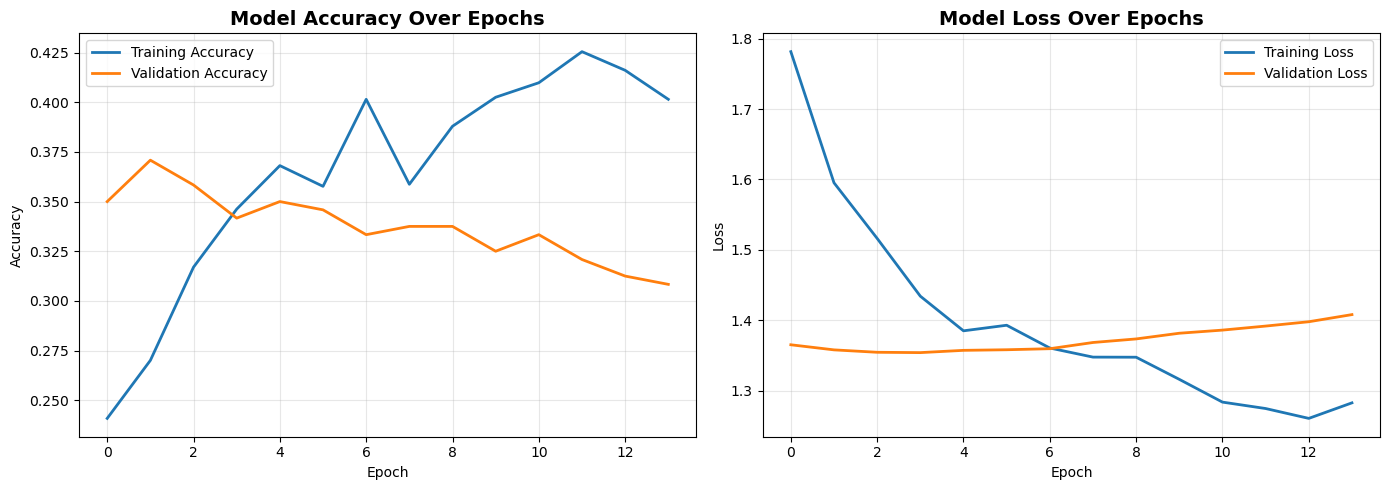

In [35]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_training.png', dpi=300, bbox_inches='tight')
plt.show()



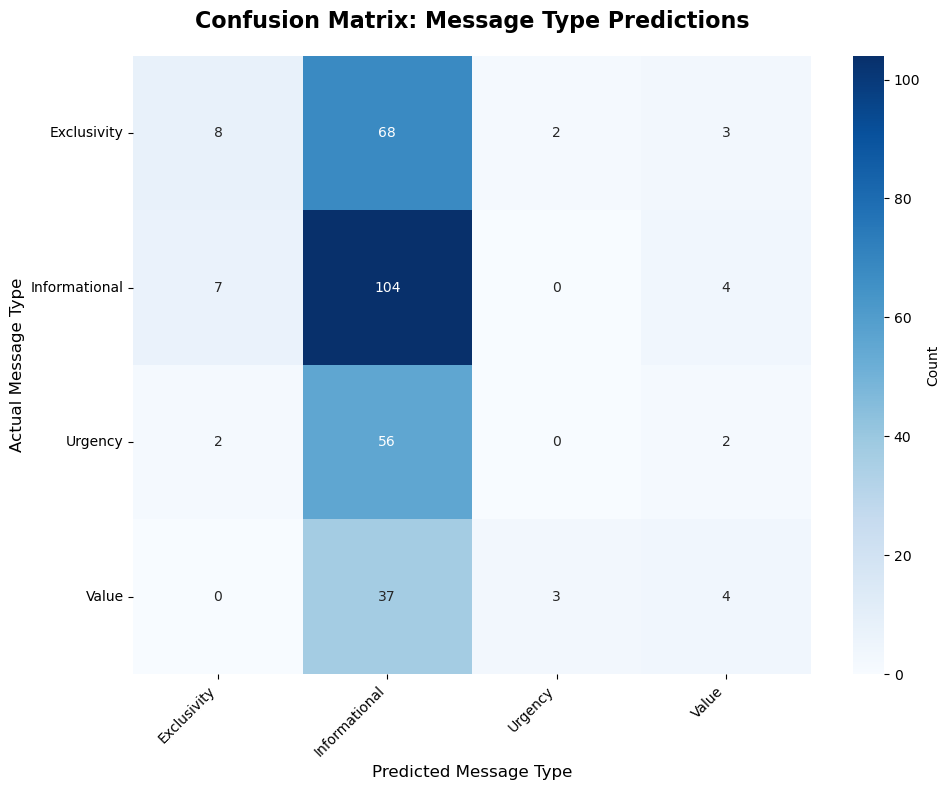

Confusion matrix saved!


In [37]:
# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: Message Type Predictions', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Message Type', fontsize=12)
plt.xlabel('Predicted Message Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")


In [39]:
# Predict message types for all customers
all_customers_features = customer_features_df.merge(
    customers_df[['customer_id', 'age', 'gender']], 
    on='customer_id', 
    how='left'
)

# Prepare features
all_customers_features['avg_satisfaction_score'] = all_customers_features['avg_satisfaction_score'].fillna(
    all_customers_features['avg_satisfaction_score'].median()
)
all_customers_features['gender_encoded'] = gender_encoder.transform(
    all_customers_features['gender'].fillna('Unknown')
)

X_all = all_customers_features[feature_columns].values
X_all_scaled = scaler.transform(X_all)

# Make predictions
predictions_probs = model.predict(X_all_scaled, verbose=0)
predictions = np.argmax(predictions_probs, axis=1)
predicted_message_types = label_encoder.inverse_transform(predictions)

# Add to dataframe
all_customers_features['recommended_message_type'] = predicted_message_types
all_customers_features['prediction_confidence'] = predictions_probs.max(axis=1)

print("\nMessage Recommendations Generated!")
print(f"Total customers: {len(all_customers_features)}")
print("\nRecommended Message Type Distribution:")
print(all_customers_features['recommended_message_type'].value_counts())



Message Recommendations Generated!
Total customers: 5000

Recommended Message Type Distribution:
recommended_message_type
Informational    4619
Exclusivity       261
Value              79
Urgency            41
Name: count, dtype: int64


In [41]:
# Segment customers by message preference and CLV
message_value_analysis = all_customers_features.groupby('recommended_message_type').agg({
    'customer_id': 'count',
    'customer_lifetime_value': ['mean', 'sum'],
    'email_open_rate': 'mean',
    'email_click_rate': 'mean',
    'prediction_confidence': 'mean'
}).round(2)

message_value_analysis.columns = ['_'.join(col).strip('_') for col in message_value_analysis.columns]
message_value_analysis = message_value_analysis.rename(columns={
    'customer_id_count': 'Customer Count',
    'customer_lifetime_value_mean': 'Avg CLV',
    'customer_lifetime_value_sum': 'Total CLV',
    'email_open_rate_mean': 'Avg Open Rate',
    'email_click_rate_mean': 'Avg Click Rate',
    'prediction_confidence_mean': 'Avg Confidence'
})

print("\nBusiness Impact by Message Type:")
print(message_value_analysis)



Business Impact by Message Type:
                          Customer Count  Avg CLV   Total CLV  Avg Open Rate  \
recommended_message_type                                                       
Exclusivity                          261  1616.07   421793.88           0.10   
Informational                       4619   920.72  4252816.19           0.06   
Urgency                               41  1259.34    51633.10           0.37   
Value                                 79  1260.08    99546.23           0.42   

                          Avg Click Rate  Avg Confidence  
recommended_message_type                                  
Exclusivity                         0.03            0.34  
Informational                       0.02            0.38  
Urgency                             0.49            0.34  
Value                               0.35            0.34  


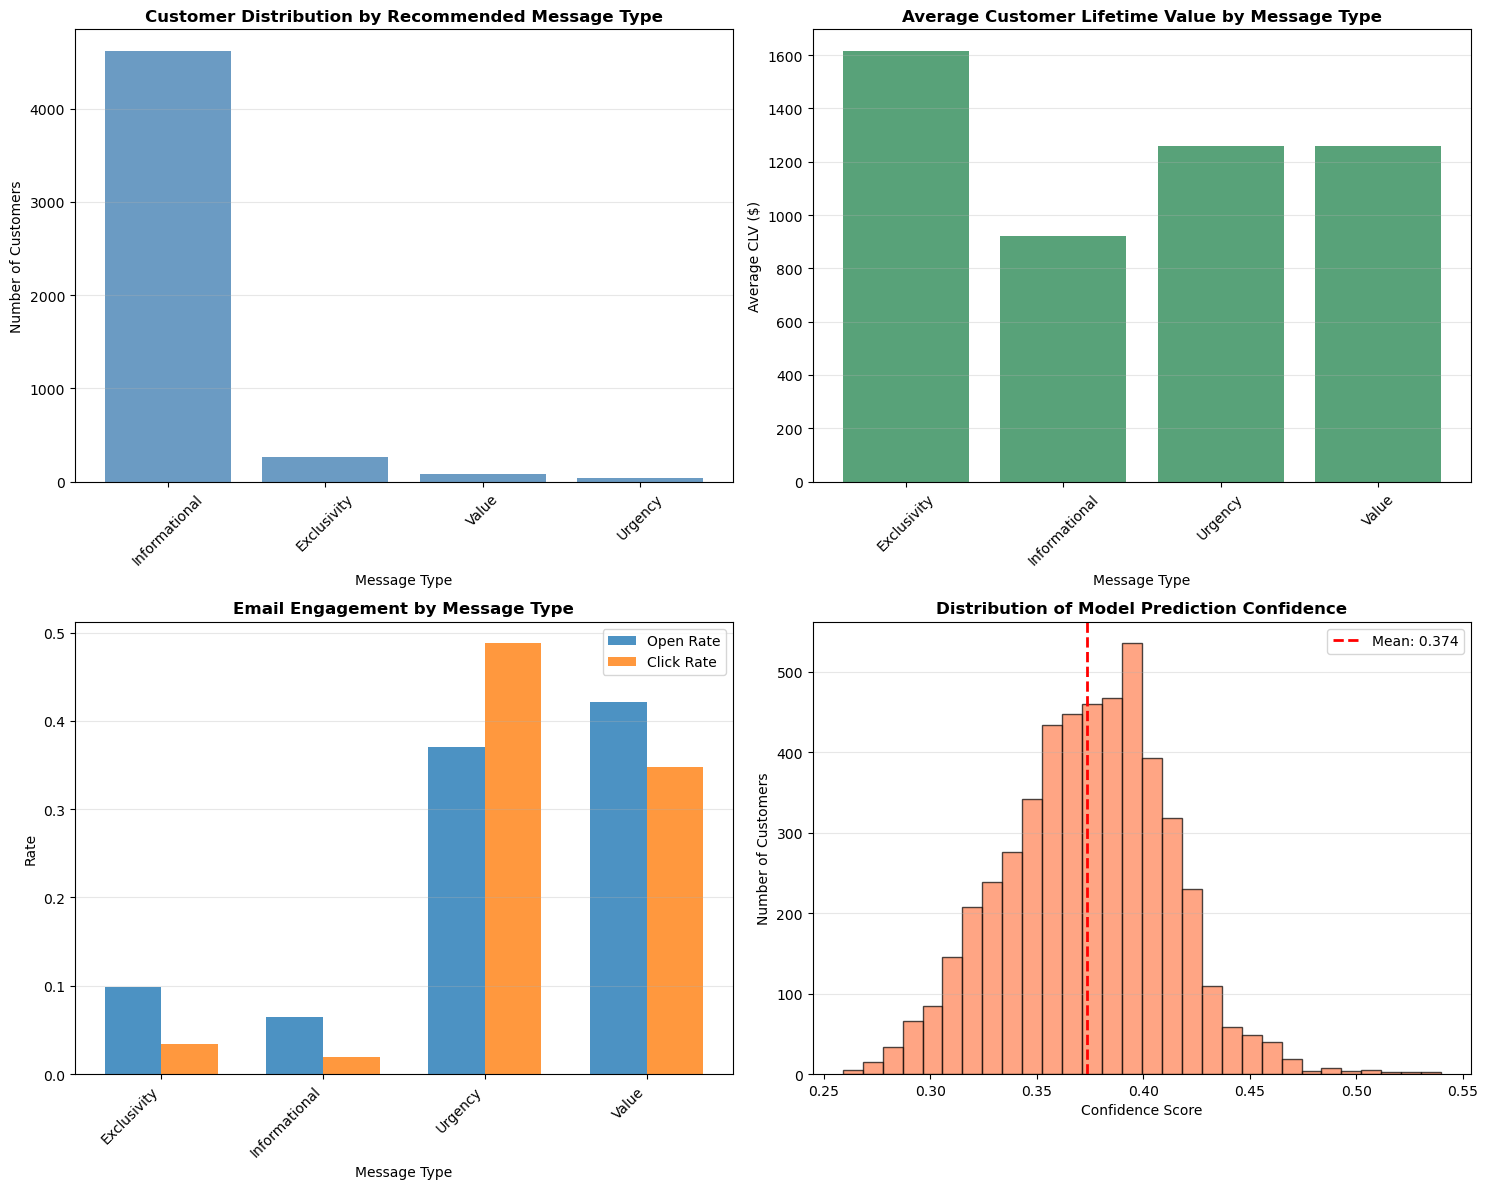

In [43]:
# Visualize business impact
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Customer distribution by message type
message_counts = all_customers_features['recommended_message_type'].value_counts()
axes[0, 0].bar(message_counts.index, message_counts.values, color='steelblue', alpha=0.8)
axes[0, 0].set_title('Customer Distribution by Recommended Message Type', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Message Type')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Average CLV by message type
avg_clv = all_customers_features.groupby('recommended_message_type')['customer_lifetime_value'].mean()
axes[0, 1].bar(avg_clv.index, avg_clv.values, color='seagreen', alpha=0.8)
axes[0, 1].set_title('Average Customer Lifetime Value by Message Type', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Message Type')
axes[0, 1].set_ylabel('Average CLV ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Email engagement rates
engagement_data = all_customers_features.groupby('recommended_message_type')[['email_open_rate', 'email_click_rate']].mean()
x = np.arange(len(engagement_data))
width = 0.35
axes[1, 0].bar(x - width/2, engagement_data['email_open_rate'], width, label='Open Rate', alpha=0.8)
axes[1, 0].bar(x + width/2, engagement_data['email_click_rate'], width, label='Click Rate', alpha=0.8)
axes[1, 0].set_title('Email Engagement by Message Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Message Type')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(engagement_data.index, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Model confidence distribution
axes[1, 1].hist(all_customers_features['prediction_confidence'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Model Prediction Confidence', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].axvline(all_customers_features['prediction_confidence'].mean(), 
                   color='red', linestyle='--', linewidth=2, label=f"Mean: {all_customers_features['prediction_confidence'].mean():.3f}")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('business_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



## Business Impact

- **Personalized Messaging at Scale:**  
  Instead of sending all customers the same promotion, marketers now have data-driven recommendations for which message style (“Urgency”, “Exclusivity”, “Value”, “Informational”) should be sent to each individual. This greatly increases the chance of engagement.

- **Higher Campaign ROI:**  
  Aligning message tone with actual customer preferences leads to higher open rates and click-through rates. Sending “VIP early access” promotions to high CLV customers, for example, maximizes revenue opportunities.

- **Efficient Resource Allocation:**  
  The marketing team can focus creative efforts on the styles and offers proven most effective for each segment, reducing guesswork and design iterations.

- **Customer Experience:**  
  Customers feel understood and valued when the content speaks to their motivations. This can drive long-term loyalty and retention.

---

## Accuracy Measure & Why 'Low' Accuracy Is Acceptable



**Justification:**
- **Multi-class Classification Problem:**  
  The model must choose between multiple message styles. If there are 4 styles, random guessing would achieve 25% accuracy.
- **Imbalanced Data & Subtle Patterns:**  
  Customers may respond to more than one style, and historical records may not capture all true preferences. Engagement is not always clear cut.
- **Noisy Real-World Data:**  
  Factors outside the data (timing, competition, holidays) impact engagement, so perfection is not expected in most commercial ML problems.
- **Business Usefulness:**  
  Even a modest lift over random (e.g. 10-20% improvement) is valuable if it moves thousands of customers to act.

---

## Key Insights

- **Message Tone Matters:**  
Patterns show that “Urgency” resonates with deal seekers, “Exclusivity” works for high-value customers, and “Value” for price-sensitive segments.

- **Customer Preferences are Complex:**  
There is no single message type for all customers. Multiple factors (engagement score, CLV, churn risk, age) influence response.

- **Automated Personalization is Possible:**  
With historical campaign and customer feature data, ML models can recommend the “what to say” for each recipient—freeing marketers to focus on strategy.

- **Model Recommendations Should Be Tested:**  
Use A/B testing in live campaigns to validate which predicted styles actually increase conversion.

- **Start Simple, Grow Sophistication:**  
Even basic models and features provide value. As more data is collected, personalization accuracy can improve.

---



## Why Should a PM in CDP Solve Message Personalization?

- **Unlocks Hidden Customer Value:**  
  The Customer Data Platform (CDP) centralizes rich behavioral, transactional, and engagement data. If message personalization is ignored, the true power of these insights goes unused. A PM who drives this initiative ensures that marketing efforts turn data into actual response.

- **Improves Business Outcomes:**  
  Personalized messaging drives higher conversions, increases loyalty, and maximizes customer lifetime value—all of which are core drivers for growth and retention in a platform business.

- **Competitive Differentiation:**  
  When most competitors are still blasting generic offers, the ability to tailor content to the individual makes your brand stand out, leading to better customer experiences.

- **Scalability and Efficiency:**  
  Manual campaign variants don’t scale. With machine learning-driven recommendations, marketers spend less time on guesswork and more time on creative or strategic activities.

- **Demonstrates CDP Value:**  
  Delivering measurable uplift in campaign metrics proves the ROI of investing in CDP capabilities, earning buy-in from leadership and setting the stage for future innovation.

## What to Expect from Post 9

**Post 9 will tackle the problem: “Deal Win Probability.”**

### Why This Problem?
After learning:
- WHO to target (segmentation, response models)
- WHAT to say (message personalization)
the next natural question in any revenue-focused organization is:
**Which opportunities are most likely to close?**



Same dataset. New problem. Message optimization.

-------

Part of the "Machine learning for product leaders" series - teaching PMs just enough ML to lead with confidence.